In [4]:
import sys
sys.path.append("/home/dell/pycharm_remote/VQ-Font/") # the absolute path to the code
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from six.moves import xrange
import os

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from model import content_enc_builder
from model import dec_builder

from torch.utils.data import Dataset
from PIL import Image, ImageFile
from model.modules import weights_init
import pprint
import json
import tqdm

In [5]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)


    def forward(self, inputs):
        # 传入的是图片经过encoder后的feature maps
        # convert inputs from BCHW
        input_shape = inputs.shape

        # Flatten input ->[BC HW]
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #得到编号
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized, perplexity, encodings

In [6]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                    (self._ema_cluster_size + self._epsilon)
                    / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [7]:
class Model(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = content_enc_builder(1,32,256)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = dec_builder(32, 1)

    def forward(self, x):
        z = self._encoder(x) #[B 256 16 16]
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


In [8]:
class CombTrain_VQ_VAE_dataset(Dataset):
    """
    CombTrain_VQ_VAE_dataset, learn the laten codebook from content font. 
    """

    def __init__(self, root, transform = None):
        self.img_path = root
        self.transform = transform
        self.imgs = self.read_file(self.img_path)
        # img = Image.open(self.imgs[0])
        # img = self.transform(img)
        # print(img.shape)


    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]
        file_path_list.sort()
        return file_path_list


    def __getitem__(self, index):
        img_name = self.imgs[index]
        #print(img_name[-5:-4])
        img = Image.open(img_name)
        if self.transform is not None:
            img = self.transform(img) #Tensor [C H W] [1 128 128]
        return img

    def __len__(self):

        return len(self.imgs)

In [ ]:
from torchvision.utils import make_grid

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

train_imgs_path = 'path/to/save/train_content_imgs/'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

train_dataset = CombTrain_VQ_VAE_dataset(train_imgs_path, transform=tensorize_transform)

train_loader = DataLoader(train_dataset, batch_size=128, batch_sampler=None, drop_last=True, pin_memory=True, shuffle=True)

num_training_updates = 50000

embedding_dim = 256
num_embeddings = 100

commitment_cost = 0.25

decay = 0

learning_rate = 2e-4

model = Model(num_embeddings, embedding_dim, commitment_cost, decay).to(device)
model.apply(weights_init("xavier"))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

model.train()
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []


def val(model,validation_loader):
    model.eval()

    valid_originals = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._encoder(valid_originals)
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)

def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


for i in xrange(num_training_updates):
    data = next(iter(train_loader))
    train_data_variance = torch.var(data)
    # print(train_data_variance)
    # show(make_grid(data.cpu().data) )
    # break
    data = data - 0.5 # normalize to [-0.5, 0.5]
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    # data_recon重构图像
    # print("vq_loss\n",vq_loss)
    recon_error = F.mse_loss(data_recon, data) / train_data_variance
    loss = recon_error + vq_loss
    # 重构损失更新encoder以及decoder,vq_loss用来更新embedding空间
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    train_vq_loss.append(vq_loss.item())

    if (i + 1) % 1000 == 0:
        print('%d iterations' % (i + 1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-1000:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-1000:]))
        print('vq_loss: %.3f' % np.mean(train_vq_loss[-1000:]))
        print()
        # show(make_grid(data.cpu().data) )

In [32]:
val_imgs_path = 'path/to/save/val_content_imgs'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

val_dataset = CombTrain_VQ_VAE_dataset(val_imgs_path, transform=tensorize_transform)

validation_loader = DataLoader(val_dataset, batch_size=8, batch_sampler=None, drop_last=True, pin_memory=True, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


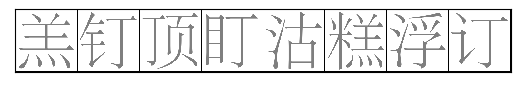

In [33]:
def val_(model,validation_loader):
    model.eval()

    valid_originals = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._encoder(valid_originals)
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    return valid_originals, valid_reconstructions
    
org, recon_out = val_(model, validation_loader)
show(make_grid((org+0.5).cpu().data), )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


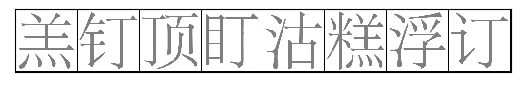

In [34]:
show(make_grid((recon_out+0.5).cpu().data), )

In [35]:
torch.save(model,'../weight/VQ-VAE_chn_.pth')    #保存所有的网络参数
torch.save(model.state_dict(),'../weight/VQ-VAE_Parms_chn_.pth')

In [ ]:
embedding_dim, num_embeddings, commitment_cost, decay = 256, 100, 0.25, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_embeddings, embedding_dim, commitment_cost, decay).to(device)
models = torch.load('../weight/VQ-VAE_chn_.pth')
encoder = models._encoder
encoder.requires_gradq = False
encoder.to("cpu")
#定义dataset
class CombTrain_VQ_VAE_dataset(Dataset):
    def __init__(self, root, transform = None):
        self.img_path = root
        self.transform = transform
        self.imgs = self.read_file(self.img_path)
        # img = Image.open(self.imgs[0])
        # img = self.transform(img)
        # print(img.shape)


    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]
        file_path_list.sort()
        return file_path_list


    def __getitem__(self, index):
        img_name = self.imgs[index]
        img = Image.open(img_name)
        if self.transform is not None:
            img = self.transform(img) #Tensor [C H W] [1 128 128]
        ret =(img_name, 
              img
        )
        return ret

    def __len__(self):

        return len(self.imgs)




train_imgs_path = 'path/to/save/all_content_imgs'
tensorize_transform = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

batch = 3500 # all content imgs

sim_dataset = CombTrain_VQ_VAE_dataset(train_imgs_path, transform=tensorize_transform)

sim_loader = DataLoader(sim_dataset, batch_size=batch, batch_sampler=None, drop_last=False, pin_memory=True)

similarity = []

def CosineSimilarity(tensor_1, tensor_2):
    normalized_tensor_1 = tensor_1 / tensor_1.norm(dim=-1, keepdim=True)
    normalized_tensor_2 = tensor_2 / tensor_2.norm(dim=-1, keepdim=True)
    return (normalized_tensor_1 * normalized_tensor_2).sum(dim=-1)


while True:
    data = next(iter(sim_loader))
    img_name = data[0]
    img_tensor = data[1]
    img_tensor = img_tensor - 0.5 # normalize to [-0.5, 0.5]
    img_tensor = img_tensor.to("cpu")
    
    #得到了conten的feature
    content_feature = encoder(img_tensor)
    # print(content_feature.shape)
    vector = content_feature.view(content_feature.shape[0], -1)
    # print(vector.shape)
    
    sim_all = {}
    for i in range(0,batch):
        char_i = hex(ord(img_name[i][-5]))[2:].upper()
        dict_sim_i = {char_i:{}}
        for j in range(0,batch):
            char_j = hex(ord(img_name[j][-5]))[2:].upper()
            similarity = CosineSimilarity(vector[i],vector[j])
            if i==j:
                similarity=1.0
            sim_i2j = {char_j:float(similarity)}
            dict_sim_i[char_i].update(sim_i2j)
        sim_all.update(dict_sim_i)

        
    dict_json=json.dumps(sim_all)#转化为json格式文件

    #将json文件保存为.json格式文件
    with open('../weight/all_char_similarity_unicode.json','w+') as file:
        file.write(dict_json)    
    break

In [17]:
with open('../weight/all_char_similarity_unicode.json','r+') as file:
    content=file.read()
    
content=json.loads(content)#将json格式文件转化为python的字典文件
print(content['4E08'])

{'4E00': 0.2094641476869583, '4E01': 0.11379217356443405, '4E03': 0.10205747187137604, '4E07': 0.007087557576596737, '4E08': 1.0, '4E09': 0.1441253423690796, '4E0A': 0.12901067733764648, '4E0B': 0.09127946197986603, '4E0D': 0.0686982125043869, '4E0E': 0.06999338418245316, '4E10': 0.0023857192136347294, '4E11': 0.1018795520067215, '4E13': -0.03635817766189575, '4E14': 0.10012045502662659, '4E16': 0.09587135910987854, '4E18': 0.09601186215877533, '4E19': 0.10186296701431274, '4E1A': 0.04026779532432556, '4E1B': 0.16864269971847534, '4E1C': 0.013585280627012253, '4E1D': 0.02225562557578087, '4E22': 0.04320104420185089, '4E24': 0.09879881888628006, '4E25': 0.04349542409181595, '4E27': 0.114617720246315, '4E2A': 0.0720180869102478, '4E2B': 0.10561937093734741, '4E2D': 0.070543572306633, '4E30': 0.049166422337293625, '4E32': 0.04158399999141693, '4E34': 0.07596849650144577, '4E38': 0.11297795921564102, '4E39': 0.00987731758505106, '4E3A': 0.05025193467736244, '4E3B': 0.1413671225309372, '4E3